In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

1


In [2]:
from scipy.ndimage import gaussian_filter
import cv2

def open_image(img_folder, img_name, img_size):
    img_path = os.path.join(img_folder, img_name)
    pil_img = Image.open(img_path).convert('RGB')
    image = T.ToTensor()(pil_img).unsqueeze(0).to("cuda")
    _, _, h, w = image.shape
    image = F.interpolate(image, size=(img_size, img_size), mode='bilinear')
    return image, h, w

def overlay_heatmap(image_path, heatmap, sigma=5):
    """
     Overlay an image with a heatmap using upsampling and Gaussian blur.
 
     Parameters:
     - image_path: Path to the input image.
     - heatmap: 2D array representing the heatmap.
     - sigma: Standard deviation for Gaussian blur (default is 5).
 
     """
    
    image = cv2.imread(image_path)
    resized_heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    normalized_heatmap = cv2.normalize(resized_heatmap, None, 0, 255, cv2.NORM_MINMAX)
    upsampled_heatmap = gaussian_filter(normalized_heatmap, sigma=sigma)
    upsampled_heatmap = cv2.applyColorMap(upsampled_heatmap.astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 0.5, upsampled_heatmap, 0.5, 0)

    color = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    plt.imshow(color)
    plt.axis('off')
    plt.show()

In [3]:
models_list = {
    "SSD-1B":'segmind/SSD-1B',
    "DINOv1_224":'vit_base_patch16_224.dino',
    "DINOv2-L-14-518":'vit_large_patch14_dinov2',
    "CLIP-VIT-L-14-224":'vit_large_patch14_clip_quickgelu_224',
    "ViT-L-16-SigLIP-256":'vit_large_patch16_siglip_256'
    }

In [4]:
from tools.features_extraction import FeatureExtractor
from diffcut.ldm import LdmExtractor

model_name = "SSD-1B"
img_size = 1024

if "SD" in model_name:
    extractor = LdmExtractor(model_name="SSD-1B", inverse_scheduler=None)
else:
    extractor = FeatureExtractor(models_list[model_name], img_size=img_size)

Loading SD model


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

SD model loaded


In [5]:
def patch_similarity(features, loc_patch, img_path):
    x_orig, y_orig = loc_patch
    _, _, h, w = features.shape
    x, y = int((h / 64) * x_orig), int((w / 64) * y_orig)
    features = F.normalize(features, dim=1)

    ref_patch = features[:, :, x, y]

    ref_patch_reshape = ref_patch.reshape(1, -1, 1, 1).to("cuda")
    dot_product = torch.sum(features.clone() * ref_patch_reshape, axis=1)

    dot_product = dot_product.to(torch.float32)
    dot_product = dot_product.detach().cpu().numpy()
    overlay_heatmap(img_path, dot_product[0], sigma=4)

def cross_patch_similarity(features, loc_patch, img_path):
    x_orig, y_orig = loc_patch
    _, _, h, w = features.shape
    x, y = int((h / 64) * x_orig), int((w / 64) * y_orig)

    feats1, feats2 = F.normalize(features[0][None], p=2, dim=1), F.normalize(features[1][None], p=2, dim=1)
    ref_patch = feats1[:, :, x, y]

    ref_patch_reshape = ref_patch.reshape(1, -1, 1, 1).to("cuda")
    dot_product = torch.sum(feats2.clone() * ref_patch_reshape, axis=1)

    dot_product = dot_product.to(torch.float32)
    dot_product = dot_product.detach().cpu().numpy()
    overlay_heatmap(img_path, dot_product[0], sigma=4)

### __Self Patch Alignement__

In [6]:
examples = {
    "2007_001239.png": (36, 36), # 3 dogs
    "2007_000925.png": (32, 20), # 2 sheeps
    "2007_005915.png": (24, 34), # sheep and lamb
    "2009_000032.png": (36, 28), # old plane
    "2008_001895.png": (34, 16), # dog
    "2009_003640.png": (32, 32), # bird
    "2010_003132.png": (42, 12), # hydroplane
    "2010_003473.png": (26, 34), # owl
    "2010_005788.png": (32, 32)} # 4 sheeps

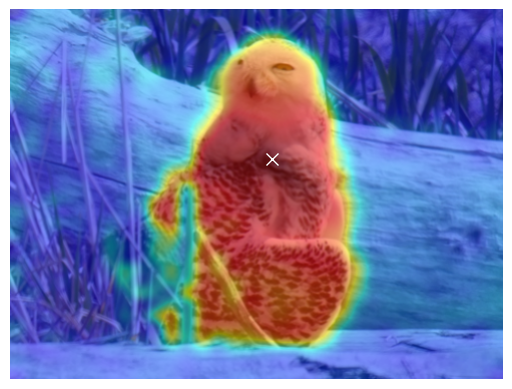

In [7]:
img_folder = "./assets/resized_imgs"
img_name = "2010_003473.png"
img_path = os.path.join(img_folder, img_name)

image, h, w = open_image(img_folder, img_name, img_size)

x_i, y_i = examples[img_name] # Position of the patch: x_i ∈ [0, 63] and y_i ∈ [0, 63]
plt.plot(int((y_i / 64) * w), int((x_i / 64) * h), marker='x', color="white", markersize=8, mew=1)


if "SD" in model_name:
    batched_input = {'img': image, 'caption': [""]}
    diffusion_features = extractor(batched_input, n_steps=10, steps=(50,), encode_method="noise")
    # Output features from the final self-attention block of the UNet encoder
    features = diffusion_features['down_blocks.2.attentions.1.transformer_blocks.3']
    features = F.normalize(features.reshape(1, img_size//32, img_size//32, -1).permute(0, 3, 1, 2), dim=1)
else:
    features = extractor(image)
    features = F.normalize(features[-1][0], dim=1)

patch_similarity(features, (x_i, y_i), img_path)

### __Cross Semantic Coherence__

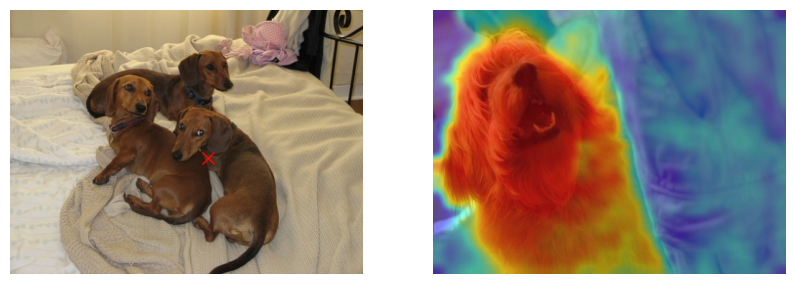

In [8]:
pairs_list = [("2007_001239.png", "2008_001895.png"), # 3 dogs vs 1 dog
         ("2010_005788.png", "2007_005915.png"), # 4 sheeps vs sheep and lamb
         ("2010_005788.png", "2007_000925.png"), # 4 sheeps vs 2 sheeps
         ("2010_003473.png", "2009_003640.png"), # owl vs bird
         ("2009_000032.png", "2010_003132.png")] # old plane vs hydroplane

img_folder = "./assets/resized_imgs"
pair = pairs_list[0] # Select the image pair in pairs_list
img_name1, img_name2 = pair[0], pair[1]

x_i, y_i = examples[img_name1] # Position of the patch: x_i ∈ [0, 63] and y_i ∈ [0, 63]

image1, h, w = open_image(img_folder, img_name1, img_size)
image2, _, _ = open_image(img_folder, img_name2, img_size)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].imshow(cv2.cvtColor(cv2.imread(os.path.join(img_folder, img_name1)), cv2.COLOR_BGR2RGB))
axes[0].plot(int((y_i / 64) * w), int((x_i / 64) * h), marker='x', color="red", markersize=8, mew=1)
axes[0].axis('off')

if "SD" in model_name:
    batched_input = {'img': torch.cat([image1, image2], dim=0), 'caption': ["", ""]}
    diffusion_features = extractor(batched_input, guidance_scale=1., n_steps=10, steps=(50,), encode_method="noise")
    features = diffusion_features['down_blocks.2.attentions.1.transformer_blocks.3']
    features = F.normalize(features.reshape(2, img_size//32, img_size//32, -1).permute(0, 3, 1, 2), dim=1)
else:
    features = extractor(torch.cat([image1, image2], dim=0))
    features = F.normalize(features[-1][0], dim=1)
        
cross_patch_similarity(features, (x_i, y_i), os.path.join(img_folder, img_name2))